In [6]:
! pip install -U duckduckgo_search>=6.2

steps：
- 使用DuckDuckGo搜索鸟的图片
- 使用DuckDuckGo搜素森林图片
- Fine-tune一个预训练模型去识别这两类
- 使用这个模型预测一个未见过的图片看性能

Step 1: Download images of birds and non-birds

In [8]:
from duckduckgo_search import  DDGS
from fastcore.all import *
def search_images(keywords,max_images=200):
    return L(DDGS().images(keywords,max_results=max_images)).itemgot('image')#DDGS().images(keywords,max_results=max_images)，返回一个包含搜索结果的迭代器。每个搜索结果是一个字典，包含图像的各种迭代器。然后转换为L对象(字典)。然后从搜索结果字典中提取image字段的值，即图像的URL


In [11]:
urls = search_images('bird photos',max_images=1)
urls[0]

'https://images.pexels.com/photos/97533/pexels-photo-97533.jpeg?cs=srgb&dl=animal-avian-bird-97533.jpg&fm=jpg'

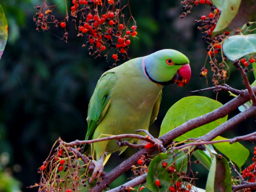

In [12]:
from fastdownload import download_url
dest = 'bird.jpg'# 保存图片的路径
download_url(urls[0],dest,show_progress=False)
from fastai.vision.all import *
im=Image.open(dest)
im.to_thumb(256,256)

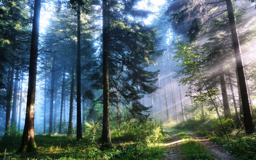

In [13]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

In [14]:
#获取更多图片保存到不同文件夹
searches = 'bird','forest'
path = Path('lesson1\\bird_or_not')
for i in searches:
    dest = (path/i)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{i} photo'))
    time.sleep(5)
    resize_images(path/i, max_size=400, dest=path/i)


In [15]:
# 对于没有正确下载的图片进行移出
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

11

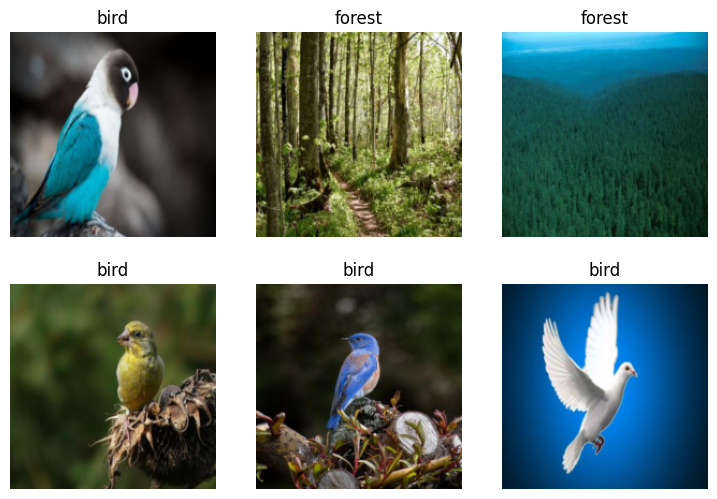

In [16]:
# 为了训练模型需要一个DataLoaders
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [17]:
# 训练模型
learn = vision_learner(dls,resnet34,metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.637621,0.006841,0.000000,00:11


epoch,train_loss,valid_loss,error_rate,time
0,0.045395,0.000217,0.000000,00:15
1,0.028138,0.000251,0.000000,00:15
2,0.019424,0.000069,0.000000,00:15


Step 3: Use our model (and build your own!)¶

In [18]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000
